# Estudio del mercado de los viedojuegos

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import warnings

In [2]:
warnings.filterwarnings('ignore')
datos=pd.read_csv('D:/Python/Kaggle/video-games-sales/vgsales-12-4-2019.csv')


In [3]:
datos.head()

,Rank,Name,basename,Genre,ESRB_Rating,Platform,Publisher,Developer,VGChartz_Score,Critic_Score,...,NA_Sales,PAL_Sales,JP_Sales,Other_Sales,Year,Last_Update,url,status,Vgchartzscore,img_url
0,1,Wii Sports,wii-sports,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,7.7,...,NaN,NaN,NaN,NaN,2006.0,NaN,http://www.vgchartz.com/game/2667/wii-sports/?...,1,NaN,/games/boxart/full_2258645AmericaFrontccc.jpg
1,2,Super Mario Bros.,super-mario-bros,Platform,NaN,NES,Nintendo,Nintendo EAD,NaN,10.0,...,NaN,NaN,NaN,NaN,1985.0,NaN,http://www.vgchartz.com/game/6455/super-mario-...,1,NaN,/games/boxart/8972270ccc.jpg
2,3,Mario Kart Wii,mario-kart-wii,Racing,E,Wii,Nintendo,Nintendo EAD,NaN,8.2,...,NaN,NaN,NaN,NaN,2008.0,11th Apr 18,http://www.vgchartz.com/game/6968/mario-kart-w...,1,8.7,/games/boxart/full_8932480AmericaFrontccc.jpg
3,4,PlayerUnknown's Battlegrounds,playerunknowns-battlegrounds,Shooter,NaN,PC,PUBG Corporation,PUBG Corporation,NaN,NaN,...,NaN,NaN,NaN,NaN,2017.0,13th Nov 18,http://www.vgchartz.com/game/215988/playerunkn...,1,NaN,/games/boxart/full_8052843AmericaFrontccc.jpg
4,5,Wii Sports Resort,wii-sports-resort,Sports,E,Wii,Nintendo,Nintendo EAD,NaN,8.0,...,NaN,NaN,NaN,NaN,2009.0,NaN,http://www.vgchartz.com/game/24656/wii-sports-...,1,8.8,/games/boxart/full_7295041AmericaFrontccc.jpg


# Preparación de los datos

Una de las problemáticas que presenta este dataset es que los valores de venta tienen como orden millones. Eso implica que cuando tenemos valores más pequeños que los 0.00 millones, no podemos tener información del valor real, únicamente podemos saber que juegos son más vendidos que los otros en función del ranking. Esto causara un pequeño sesgo cuando estudiemos si es más ventajoso usar multiplataforma o no.

Como punto de partida, vamos a formar una nueva variable uniendo Total_shiped y Global_sales. Esta variable representa las ventas totales producidas.

In [4]:
#Nueva variable
datos['producido']=datos['Total_Shipped']
datos.loc[datos['Total_Shipped'].isna(),'producido']=datos.loc[datos['Total_Shipped'].isna(),'Global_Sales']


Cuando tenemos información sobre la variable Gloval_Sales, esta se desglosa en 4 mercados. Sin embargo, en ciertas ocasiones tenemos valores faltantes. Esto puede deberse a que el valor es muy pequeño y no se ha añadido en la base de datos o que realmente no esté presente. Rellenamos estos valores como la diferencia entre el global y el resto de regiones.

In [5]:
indJ=datos['JP_Sales'].isna()
indN=datos['NA_Sales'].isna()
indP=datos['PAL_Sales'].isna()
indO=datos['Other_Sales'].isna()

In [6]:
#Añadir zona faltante JP
datos.loc[indJ,'JP_Sales']=datos.loc[indJ,'Global_Sales']-datos.loc[indJ,'NA_Sales']-datos.loc[indJ,'PAL_Sales']-datos.loc[indJ,'Other_Sales']
datos.loc[datos['JP_Sales']<0.01,'JP_Sales']=0
#Añadir zona faltante NA
datos.loc[indN,'NA_Sales']=datos.loc[indN,'Global_Sales']-datos.loc[indN,'JP_Sales']-datos.loc[indN,'PAL_Sales']-datos.loc[indN,'Other_Sales']
datos.loc[datos['NA_Sales']<0.01,'NA_Sales']=0
#Añadir zona faltante PAL
datos.loc[indP,'PAL_Sales']=datos.loc[indP,'Global_Sales']-datos.loc[indP,'NA_Sales']-datos.loc[indP,'JP_Sales']-datos.loc[indP,'Other_Sales']
datos.loc[datos['PAL_Sales']<0.01,'PAL_Sales']=0
#Añadir zona faltante Other
datos.loc[indO,'Other_Sales']=datos.loc[indO,'Global_Sales']-datos.loc[indO,'NA_Sales']-datos.loc[indO,'PAL_Sales']-datos.loc[indO,'JP_Sales']
datos.loc[datos['Other_Sales']<0.01,'Other_Sales']=0

Añadimos una nueva variable que nos indica si nuestros juegos son multiplataforma o no.

In [7]:
#Añadir indicador multiplataforma
indD=datos['Name'].duplicated(keep=False)
datos['Multiplataforma']=0
datos.loc[indD,'Multiplataforma']=1

# Análisis por plataforma y generación

### Plataformas con mayor número de juegos vendidos

El primer punto a tratar es estudiar que plataformas son las que venden un mayor número de juegos. 

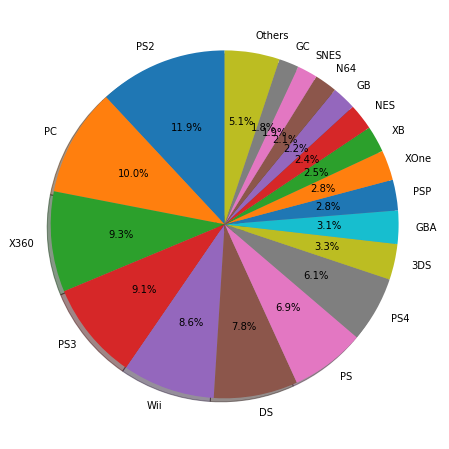

In [8]:
b=datos.groupby(by=['Platform'])['producido'].sum().sort_values(ascending=False).to_frame()
b_others=b[18:].sum()
b.reset_index(inplace=True)
b['Platform'][18]='Others'
b['producido'][18]=b_others
plt.figure(figsize=(10, 8))
a=plt.pie(b['producido'][:19], labels=b['Platform'][:19], autopct='%1.1f%%', shadow=True, startangle=90)

Viendo el comportamiento histórico a priori no hay una gran diferencia entre las cuatro grandes plataformas de videojuegos, (PS, Xbox, PC, Nintendo) a excepción de PS que entre la generación 2 y 3 suman más de un 20% de los juegos vendidos. Esta visión tiene en cuenta todos los datos históricos, lo cual no es un análisis adecuado puesto que estamos teniendo en cuenta consolas obsoletas. Nos centraremos ahora en visualizar los últimos cinco años.

### Plataformas con mayor número de juegos vendidos en los últimos años

In [9]:
datos_actuales=datos[(datos['Year']>2014)&(datos['producido'].isna()==False)]

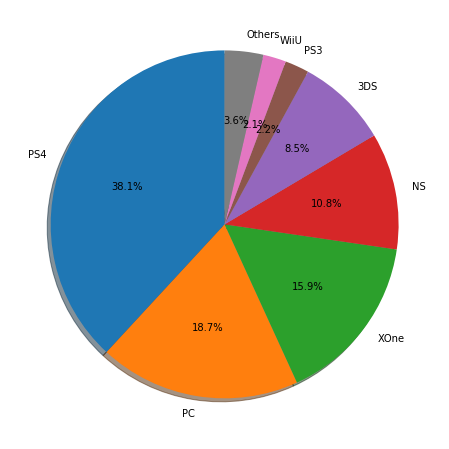

In [10]:
b=datos_actuales.groupby(by=['Platform'])['producido'].sum().sort_values(ascending=False).to_frame()
b_others=b[7:].sum()
b.reset_index(inplace=True)
b['Platform'][7]='Others'
b['producido'][7]=b_others
plt.figure(figsize=(10, 8))
a=plt.pie(b['producido'][:8], labels=b['Platform'][:8], autopct='%1.1f%%', shadow=True, startangle=90)

El comportamiento es claramente distinto, como podemos ver los juegos más vendidos publicados en los últimos años son aquellos que utilizan las plataformas de última generación, siendo ps4 la clara ganadora de todas.

### Plataforma vs multiplataforma

Para determinar cuál de las dos opciones es la más útil, vamos a comparar el comportamiento del ranking en función de si el juego es multiplataforma o no. Utilizaremos un estimador no paramétrico de la función de densidad. La idea aquí es ver de forma gráfica cuál de las dos opciones tiene una mayor probabilidad de éxito o fracaso.

He de mencionar que las funciones de densidad no están normalizadas, lo importante no son tanto los valores sino la forma.


In [11]:
datos_actuales['ESRB_Rating']=datos_actuales['ESRB_Rating'].fillna('SC')
d = {'producido':'producido', 'Multiplataforma':'Multiplataforma'}
datos_platf=datos_actuales.groupby(['Name','Genre','Publisher','ESRB_Rating']).agg({'producido':'sum','Multiplataforma':'mean'}).rename(columns=d)
datos_platf=datos_platf.reset_index()
datos_platf=datos_platf.sort_values(by=['producido'], ascending=False)
datos_platf['Rank']=np.arange(datos_platf.shape[0])+1

<Figure size 1080x720 with 0 Axes>

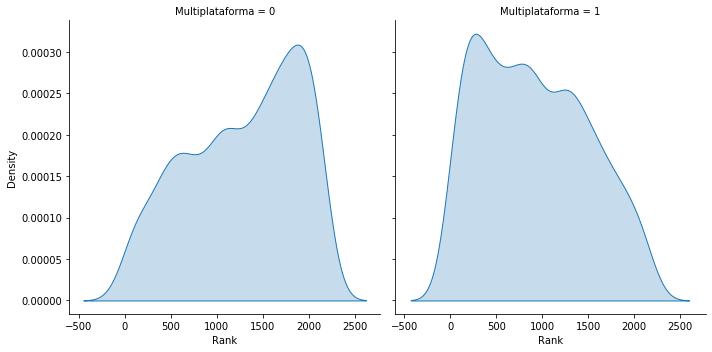

In [12]:
plt.figure(figsize=(15, 10))
sns.displot(datos_platf, x="Rank", col="Multiplataforma", kind="kde", fill=True)


En ambos casos tenemos distintas modas, que en cierta medida las podríamos ver como éxito y fracaso en función de lo cerca que estén al cero (Las modas más cercanas al cero se corresponden con los juegos éxitos, mientras que las más alejadas con los menos). A priori los videojuegos de multiplataforma parecen tener una mayor probabilidad de éxito. Para ver esto un poco más en detalle vamos ahora a estudiar este caso para cada una de las cuatro grandes plataformas.

In [13]:
datos_actuales_plat=datos_actuales[(datos_actuales['Platform']=='PS4')| (datos_actuales['Platform']=='PC')| (datos_actuales['Platform']=='XOne')| (datos_actuales['Platform']=='NS')]

<Figure size 1080x720 with 0 Axes>

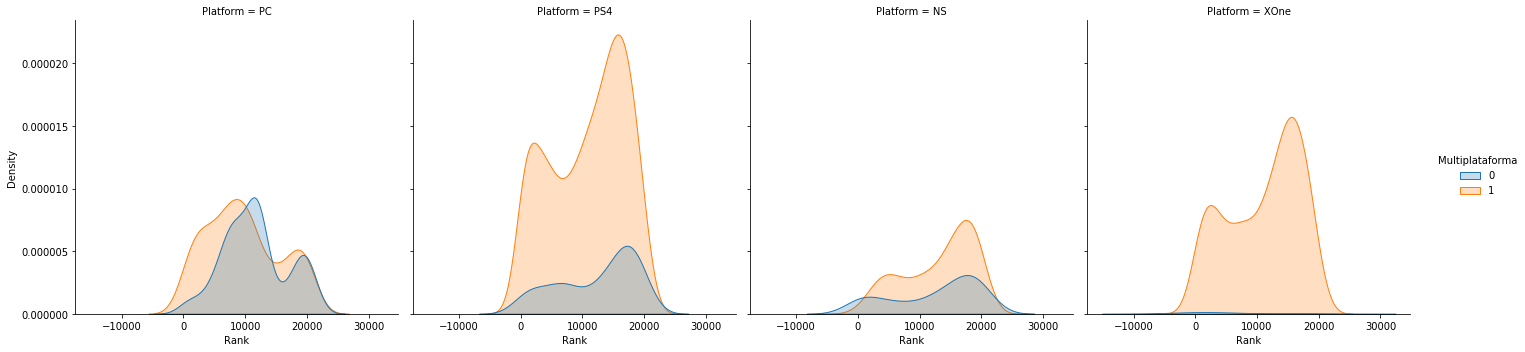

In [14]:
plt.figure(figsize=(15, 10))
sns.displot(datos_actuales_plat, x="Rank", hue="Multiplataforma", kind="kde",col="Platform", fill=True)

A excepción de la Xbox que apenas tiene títulos propios, vemos que la estructura es bastante similar. De apostar por una plataforma esa sería ps, sin embargo, hay una serie de detalles que conviene mencionar. El hecho de que no tengamos toda la información de las ventas reales hace que los juegos multiplataformas tengan un sesgo negativo en el análisis como se mencionó anteriormente. Lo segundo, pero no menos importante es que las plataformas invierten mucho dinero en conseguir exclusividad en ciertos juegos con una fan base grande. Esto genera que parte de los juegos éxitos exclusivos a una plataforma son éxitos no por ser exclusivos si no por tener un gran número de seguidores. 

La decisión de elegir si apostar por una plataforma o multiplataforma depende también del incremento en el coste que pueda suponer desarrollar un juego en varias plataformas. Pero como se ha visto en el análisis no parece que el hecho de ser exclusivo de una plataforma incentive a una mayor venta de esta, mientras que la multiplataforma en términos absolutos si genera más ventas.


# Análisis por Genero

Ya hemos determinado que la mejor decisión podría ser desarrollar un juego multiplataforma, sin embargo, este resultado no es 100% seguro si no estudiamos previamente los géneros de videojuegos más demandados, y si esos géneros son comunes para las distintas plataformas. No tendría ningún sentido desarrollar un juego multiplataforma cuando solo tiene demanda para una plataforma.

### Qué genero de videojuegos es el más demandado

Comenzaremos viendo que juegos son los más vendidos en términos absolutos

In [15]:
datos_genre = datos_actuales.groupby(by=['Genre'])['producido'].sum()
datos_genre = datos_genre.reset_index()
datos_genre['count']=datos_platf['Genre'].value_counts().reset_index().sort_values(by=['index'])['Genre'].values
datos_genre = datos_genre.sort_values(by=['producido'], ascending=False)
# data_genre

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

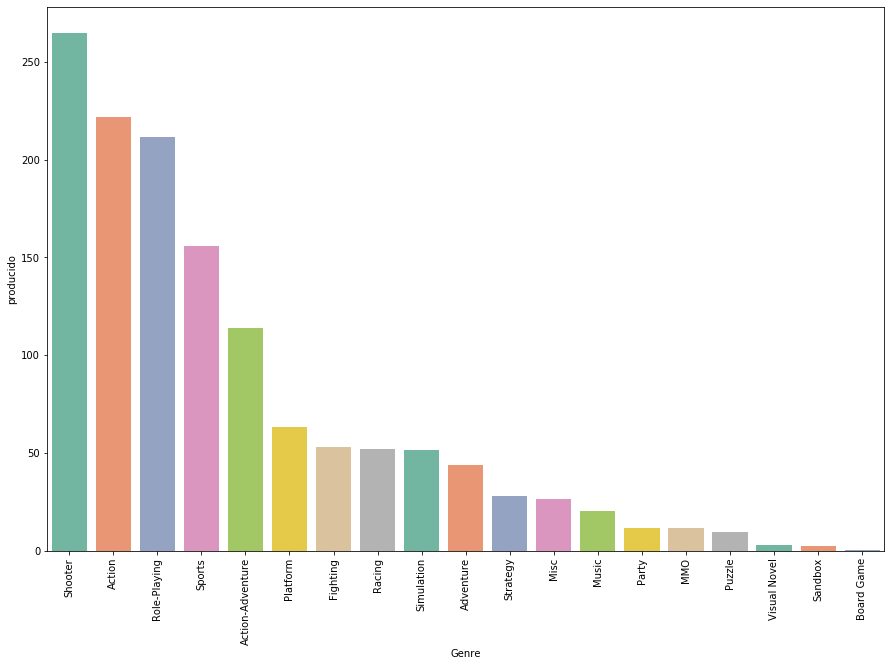

In [16]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Genre", y="producido", palette="Set2",data=datos_genre)
plt.xticks(rotation=90)

Estos son los géneros que más ventas generan. Sin embargo, un género puede tener un número muy grande de ventas y que el número de juegos publicados sea muy grande, por lo que implica una mayor competencia y una menor ganancia, mientras que otro género que haya generado un número menor de ventas, pero con una cantidad mucho menor de juegos puede generar una mayor ganancia. Lo que haremos ahora es estudiar la ganancia media por género.

In [17]:
datos_genre['producido']=datos_genre['producido']/datos_genre['count']
datos_genre = datos_genre.sort_values(by=['producido'], ascending=False)

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

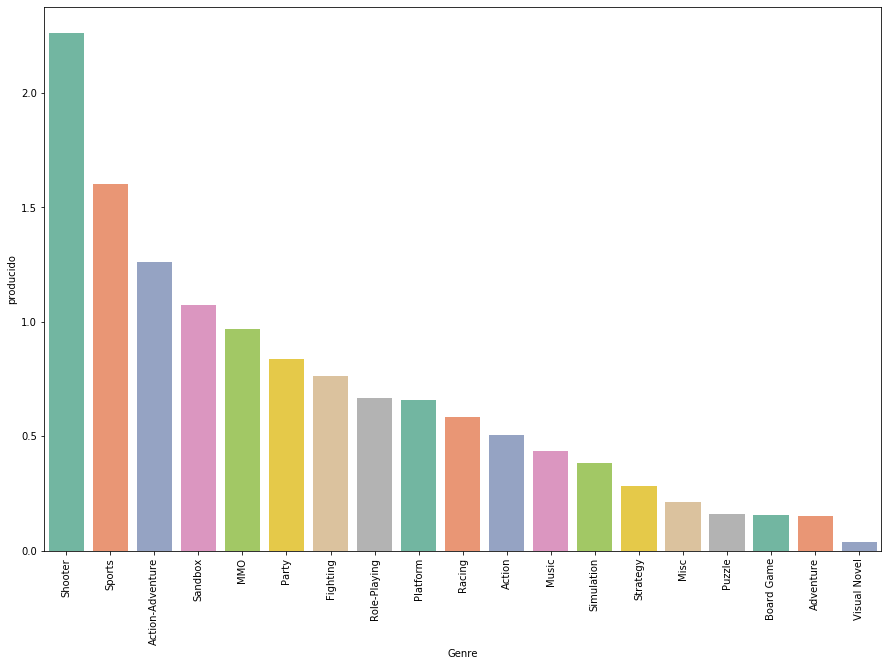

In [18]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Genre", y="producido", palette="Set2",data=datos_genre)
plt.xticks(rotation=90)

### Análisis por cada una de las cuatro consolas principales 

Como hemos visto los shooter son la categoría que destaca sobre todas, pero tiene el mismo impacto en todas las consolas? El siguiente paso es estudiar cada una de estas categorías en función de la plataforma.

In [19]:
datos_ps4=datos_actuales[datos_actuales['Platform']=='PS4']
datos_pc=datos_actuales[datos_actuales['Platform']=='PC']
datos_xone=datos_actuales[datos_actuales['Platform']=='XOne']
datos_ns=datos_actuales[datos_actuales['Platform']=='NS']

In [20]:
#PS4
datos_genre_ps4 = datos_ps4.groupby(by=['Genre'])['producido'].sum()
datos_genre_ps4 = datos_genre_ps4.reset_index()
datos_genre_ps4 = datos_genre_ps4.sort_values(by=['producido'], ascending=False)
#PS4
datos_genre_pc = datos_pc.groupby(by=['Genre'])['producido'].sum()
datos_genre_pc = datos_genre_pc.reset_index()
datos_genre_pc = datos_genre_pc.sort_values(by=['producido'], ascending=False)
#PS4
datos_genre_xone = datos_xone.groupby(by=['Genre'])['producido'].sum()
datos_genre_xone = datos_genre_xone.reset_index()
datos_genre_xone = datos_genre_xone.sort_values(by=['producido'], ascending=False)
#PS4
datos_genre_ns = datos_ns.groupby(by=['Genre'])['producido'].sum()
datos_genre_ns = datos_genre_ns.reset_index()
datos_genre_ns = datos_genre_ns.sort_values(by=['producido'], ascending=False)

### PS4

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

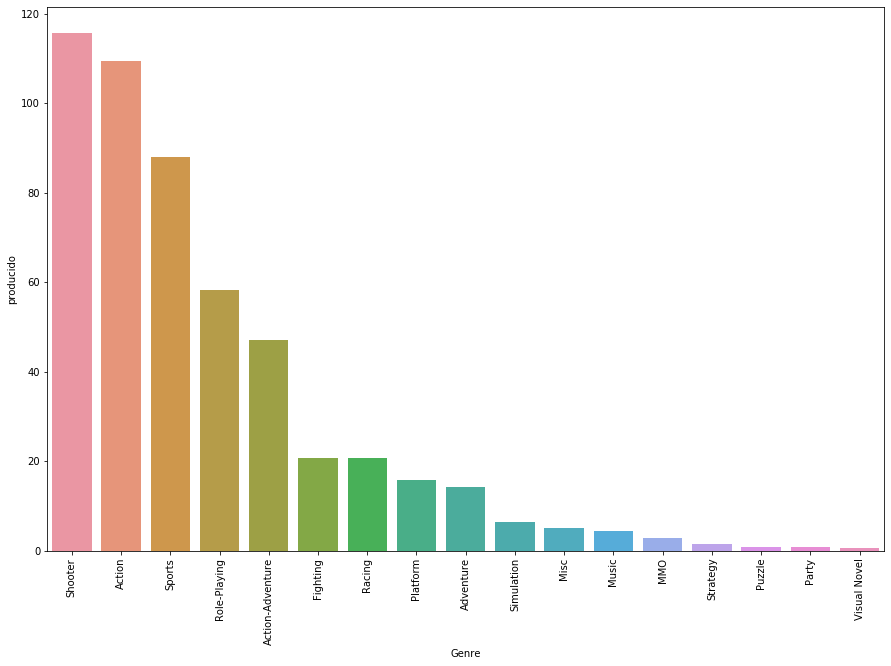

In [21]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Genre", y="producido", data=datos_genre_ps4)
plt.xticks(rotation=90)


### PC

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17]),
 <a list of 18 Text xticklabel objects>)

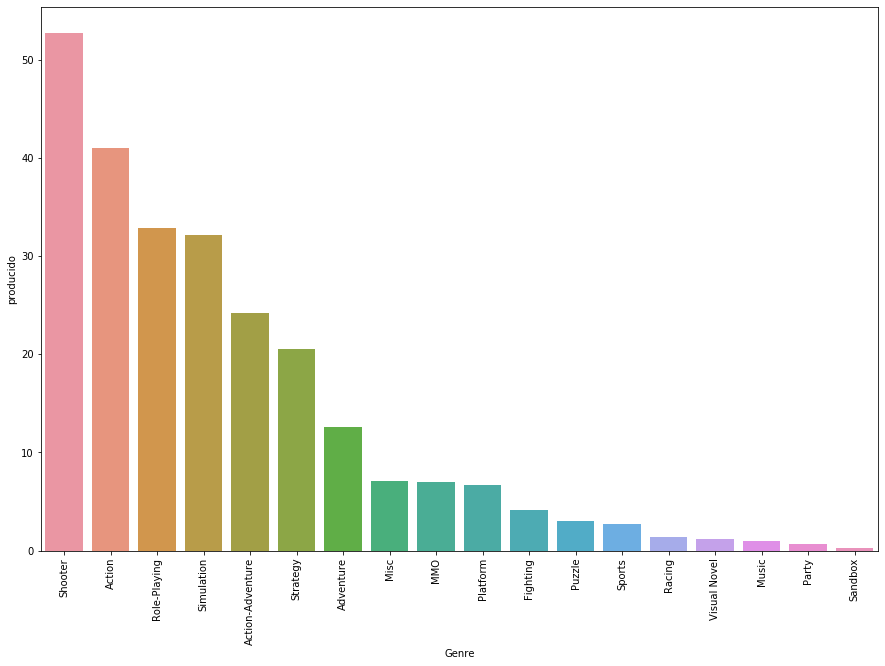

In [22]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Genre", y="producido", data=datos_genre_pc)
plt.xticks(rotation=90)

### Xbox

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16]),
 <a list of 17 Text xticklabel objects>)

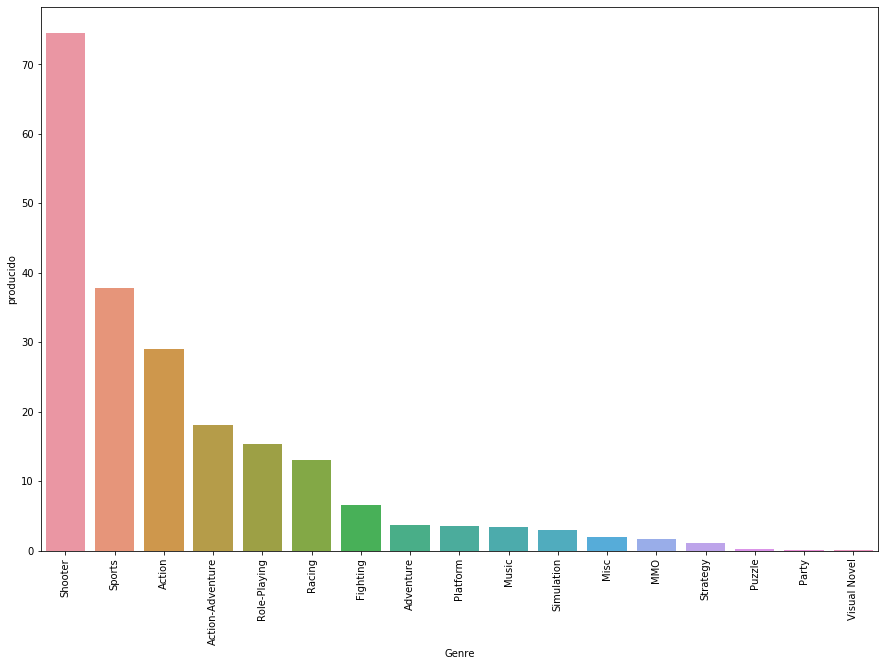

In [23]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Genre", y="producido", data=datos_genre_xone)
plt.xticks(rotation=90)

### Nintendo

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

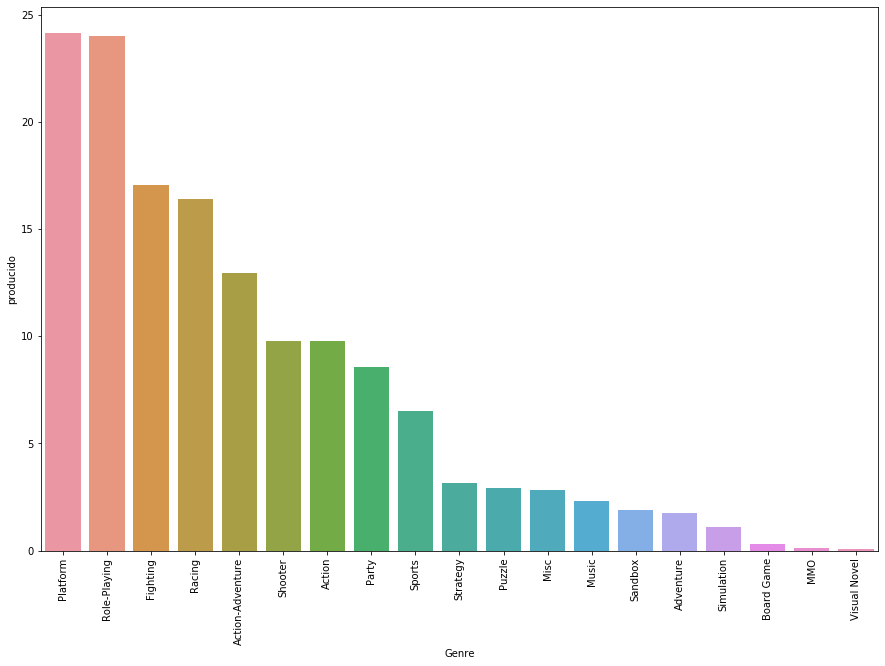

In [24]:
plt.figure(figsize=(15, 10))
sns.barplot(x="Genre", y="producido", data=datos_genre_ns)
plt.xticks(rotation=90)

# Análisis por mercado

El estudio de los mercados esta ligeramente sesgado, puesto que existen un número de juegos importante en el que no sabes qué cantidad ha demandado cada uno. Esto ocurre principalmente con los juegos de pc. Existen algún dataset alternativo, sin embargo, en muchos casos son contradictorios con el propio dataset. En este análisis únicamente vamos a trabajar con el dataset original.

(array([0, 1, 2, 3]), <a list of 4 Text xticklabel objects>)

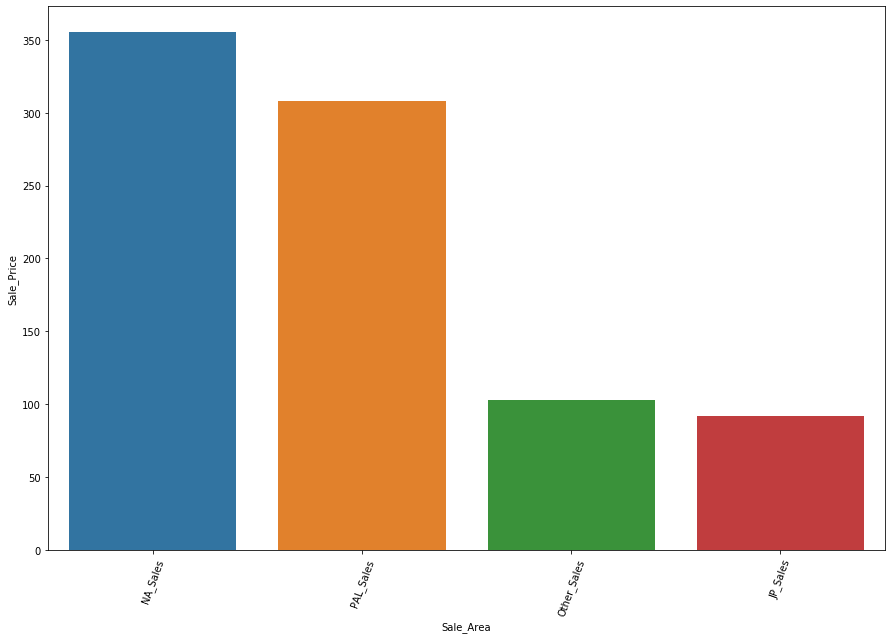

In [25]:
datos_actuales_genre = datos_actuales[['Genre', 'NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales']]
# comp_genre
comp_map = datos_actuales_genre.groupby(by=['Genre']).sum()
comp_map=comp_map.sort_values(by=['NA_Sales'], ascending=False)
comp_table = comp_map.reset_index()
comp_table = pd.melt(comp_table, id_vars=['Genre'], value_vars=['NA_Sales', 'PAL_Sales', 'JP_Sales', 'Other_Sales'], var_name='Sale_Area', value_name='Sale_Price')
a=comp_table.groupby(by=['Sale_Area']).sum().reset_index()
a=a.sort_values(by=['Sale_Price'], ascending=False)
plt.figure(figsize=(15, 10))
sns.barplot( y='Sale_Price', x='Sale_Area', data=a)
plt.xticks(rotation=70)

### Por género

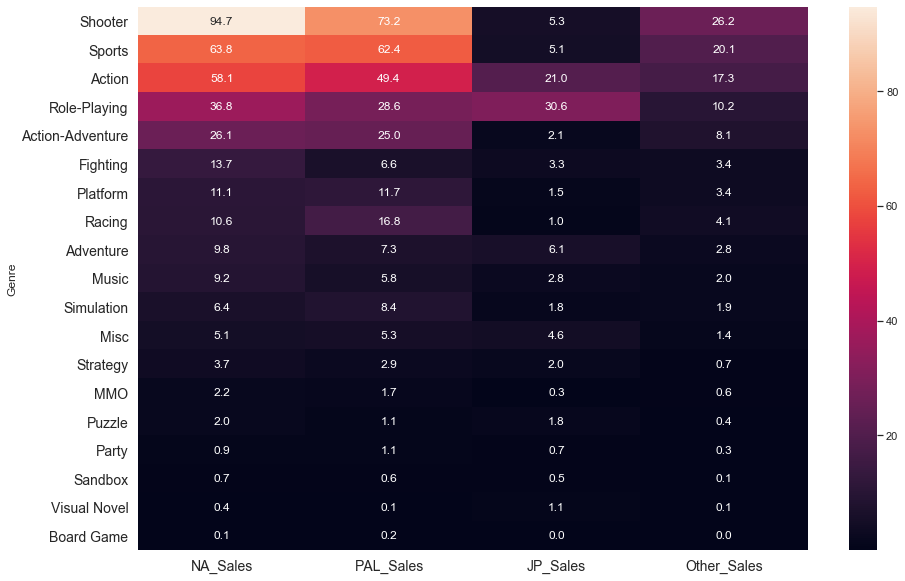

In [26]:
# comp_map
plt.figure(figsize=(15, 10))
sns.set(font_scale=1)
sns.heatmap(comp_map, annot=True, fmt = '.1f')

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.show()

El género de shooter es posiblemente la mejor opción a seguir, pero con la consecuencia de perder el mercado japón. La segunda mejor opción es el género sport y ocurre lo mismo que con el shooter. A pesar de la pérdida del mercado japones, estas dos categorías siguen siendo líderes.  Por otro lado, géneros como action y role tienen grandes ventas en todos los mercados, aunque cabe destacar que estos dos géneros tenían mayor competencia en función de los beneficios, con lo que no son la mejor opción. Adicional a esto hay que añadir que apenas tenemos información sobre las ventas de pc. Teniendo en cuenta este detalle nos damos cuenta que los juegos de sport eran poco demandados en esta plataforma y sin embargo, aquí son la segunda mejor opción. Esto es debido al sesgo que se mencionó al principio de la sección.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18]),
 <a list of 19 Text xticklabel objects>)

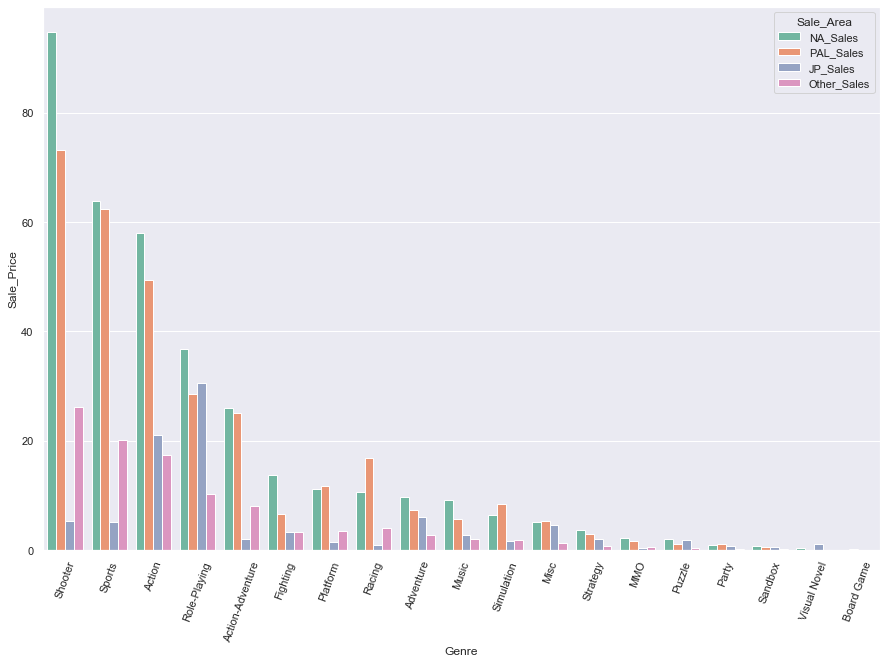

In [27]:
plt.figure(figsize=(15, 10))
sns.barplot(x='Genre', y='Sale_Price', hue='Sale_Area', palette="Set2", data=comp_table)
plt.xticks(rotation=70)


# Análisis top ventas

El ESRB es un tipo de clasificación que se da a los videojuegos en función del rango de edad apto. Esto nos describe un poco las características que tiene que tener el videojuego que quiere desarrollar la plataforma.

In [28]:
datos_shooter=datos_platf[datos_platf['Genre']=='Shooter']


In [29]:
datos_shooter_ESRB=datos_shooter[datos_shooter['ESRB_Rating'].isna()==False]
datos_shooter_nESRB=datos_shooter[datos_shooter['ESRB_Rating'].isna()]


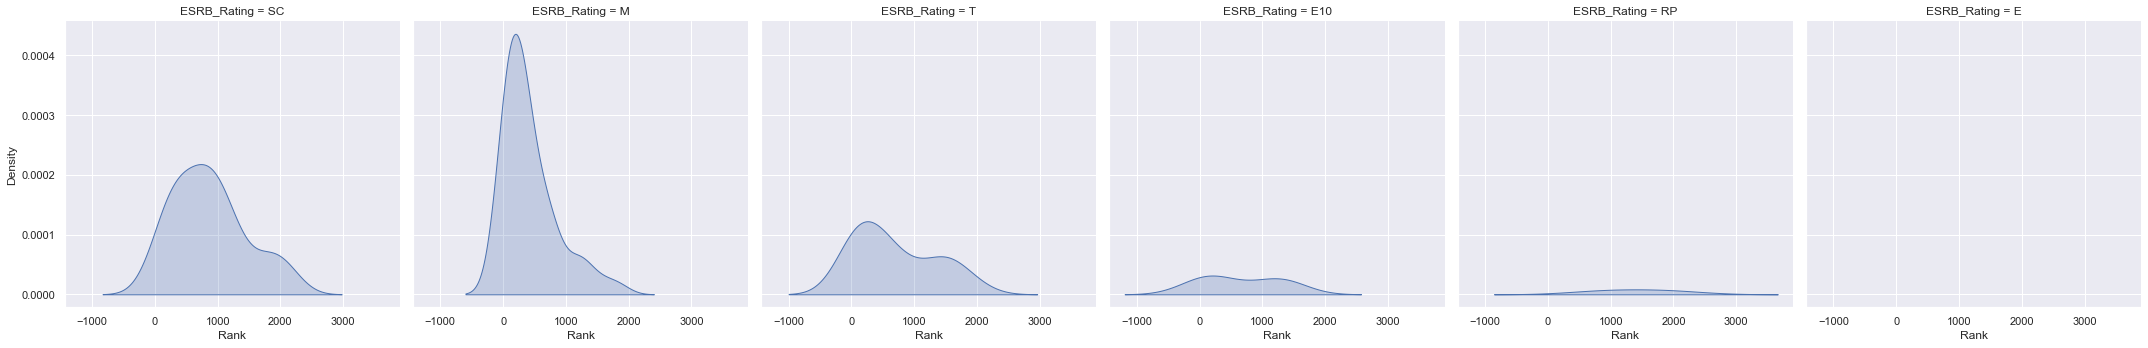

In [30]:
sns.displot(datos_shooter_ESRB, x="Rank", col='ESRB_Rating', kind="kde", fill=True)


Los juegos que destacan son los de la categoría M. Esta categoría corresponde a adultos o mayores de 17 acompañados. Lo que nos quiere decir esto es que habrá una mayor probabilidad de éxito si el juego a desarrollar es un juego para un público más adulto.

Una posible opción del cliente es llegar a un acuerdo con una distribuidora para lanzar su producto. Trataremos de elegir ahora aquella productora que tiene unos mejores resultados en ventas.

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14]),
 <a list of 15 Text xticklabel objects>)

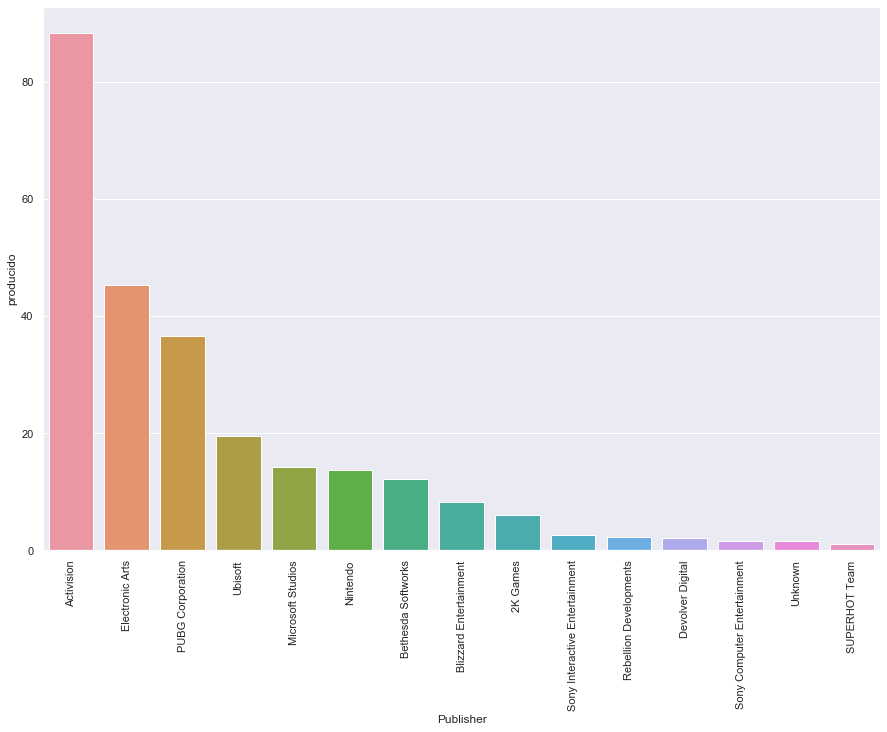

In [31]:
datos_shooter_ESRB_pu = datos_shooter_ESRB.groupby(by=['Publisher'])['producido'].sum()
datos_shooter_ESRB_pu= datos_shooter_ESRB_pu.reset_index()
datos_shooter_ESRB_pu = datos_shooter_ESRB_pu.sort_values(by=['producido'], ascending=False)
plt.figure(figsize=(15, 10))
sns.barplot(x="Publisher", y="producido", data=datos_shooter_ESRB_pu.iloc[0:15,:],ci=None)
plt.xticks(rotation=90)

Activision es  la desarrolladora ideal, prácticamente duplica las ventas de su competencia.

Imponiendo todas estas clasificaciones tenemos como resultado:

In [32]:
datos_shooter_final=datos_shooter_ESRB[((datos_shooter_ESRB['Publisher']=='Activision'))&(datos_shooter_ESRB['ESRB_Rating']=='M')]

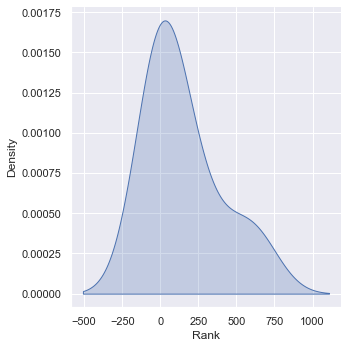

In [33]:
sns.displot(datos_shooter_final, x="Rank", kind="kde", fill=True)

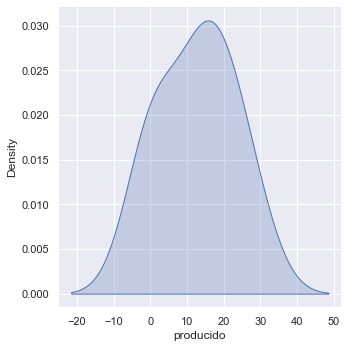

In [34]:
sns.displot(datos_shooter_final, x="producido", kind="kde", fill=True)

In [35]:
datos_shooter_final['producido'].mean()

12.623333333333335